# Homework RNN
1. Download data for GDP growth rates, Inflation, Unemployment Rates and Money growth for Norway.
2. Load the data into Python, check for NaN
3. Run a RNN with and without LSTM on only GDP.
4. Add the other covariates as features - if your model fails (change the density of the layers).
5. Compare your forecasts graphically across all 4 models.
6. Split your into a training and test/in sample forecast sample and forecast using the test sample only.

In [94]:
# Import the necessary packages
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Use the standard tqdm callback instead of the notebook-specific one
callbacks = [TqdmCallback(verbose=1)]


0epoch [05:18, ?epoch/s]




In [95]:
# Setting the working directory
data_path = 'C:/Users/henrik.knudsen/OneDrive - BI Norwegian Business School (BIEDU)/Desktop/BI-Skole/3 Semester/DL and XAI/Labs/Lab 4/'

# Setting file name
file_name = 'NorwayMacro.csv'

# Read CSV file
data = pd.read_csv(os.path.join(data_path, file_name))

# Extracting relevant columns
data = data[["date", "M2", "Unemployment", "GDP", "Inflation"]]

# Checking for NaN values
print("Missing values per columns:")
print(data.isna().sum())

# Dropping the rows wiht NaN
data.dropna(inplace=True)
print("Missing values per columns after:")
print(data.isna().sum())

Missing values per columns:
date             0
M2              12
Unemployment     0
GDP             97
Inflation       96
dtype: int64
Missing values per columns after:
date            0
M2              0
Unemployment    0
GDP             0
Inflation       0
dtype: int64


             M2  Unemployment  GDP  Inflation
date                                         
2016-02-01  4.6           5.6  0.1        0.6
2016-03-01  3.7           5.1  0.8        0.2
2016-04-01  5.4           5.0  0.6        1.1
2016-05-01  3.3           4.9  0.5        0.1
2016-06-01  4.6           4.6  0.6        0.7


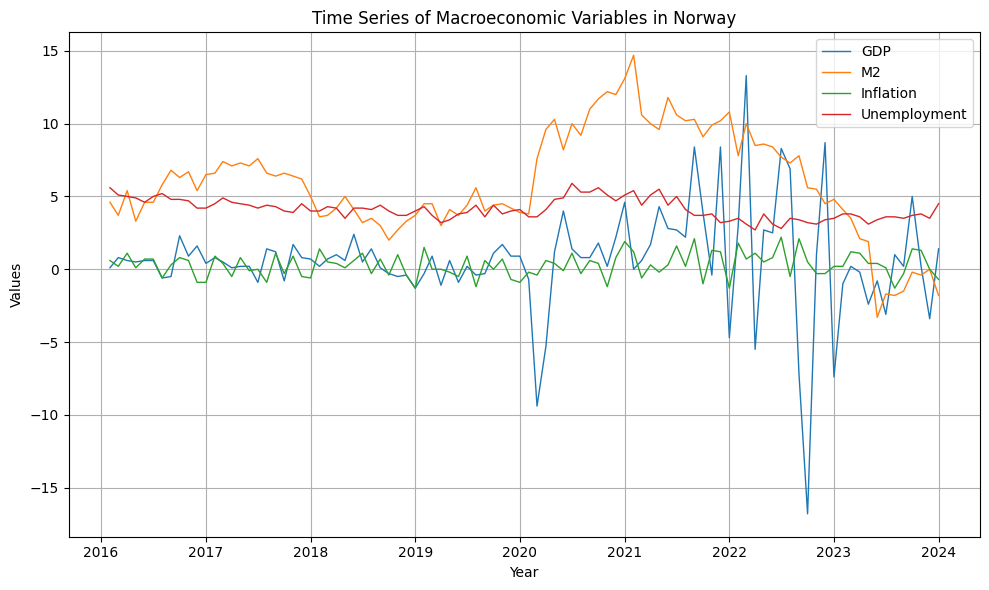

In [96]:
# Setting the date-column to appropiate format
data["date"] = pd.to_datetime(data["date"], format="%YM%m")

# Set date as index
data.set_index("date", inplace=True)
print(data.head())

# Plotting the values
plt.figure(figsize=(10, 6))  # Adjust the figure size for better readability
plt.plot(data.index, data['GDP'], label='GDP', linewidth=1)
plt.plot(data.index, data['M2'], label='M2', linewidth=1)
plt.plot(data.index, data['Inflation'], label='Inflation', linewidth=1)
plt.plot(data.index, data['Unemployment'], label='Unemployment', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Time Series of Macroeconomic Variables in Norway')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [97]:
# We need to scale our features, in order to "up" the performance
scaler = MinMaxScaler()

# Fit and trasnform the data
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

In [98]:
# Define the training and test split
train_ratio = 0.8
train_size = int(len(scaled_df)*train_ratio)
train_data = scaled_df.iloc[:train_size]
test_data = scaled_df.iloc[train_size:]

In [99]:
# Define parameters
time_window = 12
batch_size = 32

In [100]:
# Create TimeSeriesGenerators

## Univariate (GDP only) ##
train_gdp = train_data[['GDP']].values.astype(np.float32)
test_gdp = test_data[['GDP']].values.astype(np.float32)

train_gen_univariate = TimeseriesGenerator(
    train_gdp,
    train_gdp,
    length=time_window,
    batch_size=batch_size
)

val_gen_univariate = TimeseriesGenerator(
    test_gdp,
    test_gdp,
    length=time_window,
    batch_size=batch_size
)

In [101]:
# Multivariate (GDP + M2 + Unemployment + Inflation)
train_multivariate = train_data[['GDP', 'M2', 'Unemployment', 'Inflation']].values.astype(np.float32)
test_multivariate = test_data[['GDP', 'M2', 'Unemployment', 'Inflation']].values.astype(np.float32)

train_gen_multivariate = TimeseriesGenerator(
    train_multivariate,
    train_multivariate[:, 0],  # Target is GDP
    length=time_window,
    batch_size=batch_size
)

val_gen_multivariate = TimeseriesGenerator(
    test_multivariate,
    test_multivariate[:, 0],  # Target is GDP
    length=time_window,
    batch_size=batch_size
)


In [102]:
# Define a function to build models
def build_model(model_type='RNN', input_shape=(time_window, 1), units=50):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, activation='relu', input_shape=input_shape))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Initialize EarlyStopping and ModelCheckpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialize callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [103]:
# Build and train models
models = {
    'RNN_Univariate': build_model('RNN', input_shape=(time_window, 1)),
    'LSTM_Univariate': build_model('LSTM', input_shape=(time_window, 1)),
    'RNN_Multivariate': build_model('RNN', input_shape=(time_window, 4)),
    'LSTM_Multivariate': build_model('LSTM', input_shape=(time_window, 4)),
}

history = {}


c:\Users\henrik.knudsen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [104]:
# Train each model and save the history
history['RNN_Univariate'] = models['RNN_Univariate'].fit(
    train_gen_univariate,
    epochs=100,
    validation_data=val_gen_univariate,
    verbose=0  # Change to verbose=1 if you want to see the training progress
)

history['LSTM_Univariate'] = models['LSTM_Univariate'].fit(
    train_gen_univariate,
    epochs=100,
    validation_data=val_gen_univariate,
    verbose=0
)

history['RNN_Multivariate'] = models['RNN_Multivariate'].fit(
    train_gen_multivariate,
    epochs=100,
    validation_data=val_gen_multivariate,
    verbose=0
)

history['LSTM_Multivariate'] = models['LSTM_Multivariate'].fit(
    train_gen_multivariate,
    epochs=100,
    validation_data=val_gen_multivariate,
    verbose=0
)


c:\Users\henrik.knudsen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [105]:
# Define predction function
def make_predictions(model, generator, scaler, multivariate=False):
    preds = model.predict(generator)
    
    if multivariate:
        # Initialize an array with zeros for all features
        preds_extended = np.zeros((preds.shape[0], scaler.scale_.shape[0]))
        preds_extended[:, 0] = preds[:, 0]  # Only GDP is predicted

        # Inverse transform
        preds_inversed = scaler.inverse_transform(preds_extended)[:, 0]

        # Actual values
        actual = generator.targets
        actual_extended = np.zeros((actual.shape[0], scaler.scale_.shape[0]))
        actual_extended[:, 0] = actual.flatten()  # Flatten to match shape
        actual_inversed = scaler.inverse_transform(actual_extended)[:, 0]
    else:
        # For univariate, pad the array with zeros for other features
        preds_extended = np.zeros((preds.shape[0], scaler.scale_.shape[0]))
        preds_extended[:, 0] = preds.flatten()  # Flatten to match shape

        # Inverse transform
        preds_inversed = scaler.inverse_transform(preds_extended)[:, 0]

        # Actual values
        actual = generator.targets
        actual_extended = np.zeros((actual.shape[0], scaler.scale_.shape[0]))
        actual_extended[:, 0] = actual.flatten()  # Flatten to match shape
        actual_inversed = scaler.inverse_transform(actual_extended)[:, 0]

    return actual_inversed, preds_inversed

In [106]:
# Generate predictions
predictions = {}
for key, model in models.items():
    if 'Multivariate' in key:
        actual, preds = make_predictions(model, val_gen_multivariate, scaler, multivariate=True)
    else:
        actual, preds = make_predictions(model, val_gen_univariate, scaler, multivariate=False)
    predictions[key] = {'actual': actual, 'preds': preds}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [110]:
# Manual calculation of RMSE
def rmse(actual, preds):
    return np.sqrt(np.mean((actual - preds) ** 2))

# Manual calculation of MAE
def mae(actual, preds):
    return np.mean(np.abs(actual - preds))


# Evaluate models using manual RMSE and MAE
def evaluate_model(actual, preds, model_name):
    # Ensure that actual and preds have the same length
    actual = actual[:len(preds)]
    
    rmse_value = rmse(actual, preds)
    mae_value = mae(actual, preds)
    
    print(f"{model_name} - RMSE: {rmse_value:.4f}, MAE: {mae_value:.4f}")
    return rmse_value, mae_value

# Dictionary to store metrics
metrics = {}

# Loop through predictions and evaluate each model
for key, value in predictions.items():
    rmse_value, mae_value = evaluate_model(value['actual'], value['preds'], key)
    metrics[key] = {'RMSE': rmse_value, 'MAE': mae_value}


RNN_Univariate - RMSE: 5.1895, MAE: 4.5859
LSTM_Univariate - RMSE: 5.0271, MAE: 4.3274
RNN_Multivariate - RMSE: 4.4406, MAE: 3.6607
LSTM_Multivariate - RMSE: 4.7259, MAE: 4.1905



Predictions DataFrame:
            Actual_GDP  RNN_Univariate  LSTM_Univariate  RNN_Multivariate  \
Date                                                                        
2022-06-01    8.241528        6.494619         6.536579          7.689928   
2022-07-01   11.709967        7.168836         6.457481          7.401280   
2022-08-01   10.872757        6.149517         6.160269          7.736435   
2022-09-01    2.440864        7.213694         6.094115          5.740537   
2022-10-01   -3.300000        5.782723         6.329465          5.436232   

            LSTM_Multivariate  
Date                           
2022-06-01           6.765470  
2022-07-01           6.337812  
2022-08-01           5.906892  
2022-09-01           5.178340  
2022-10-01           5.022777  


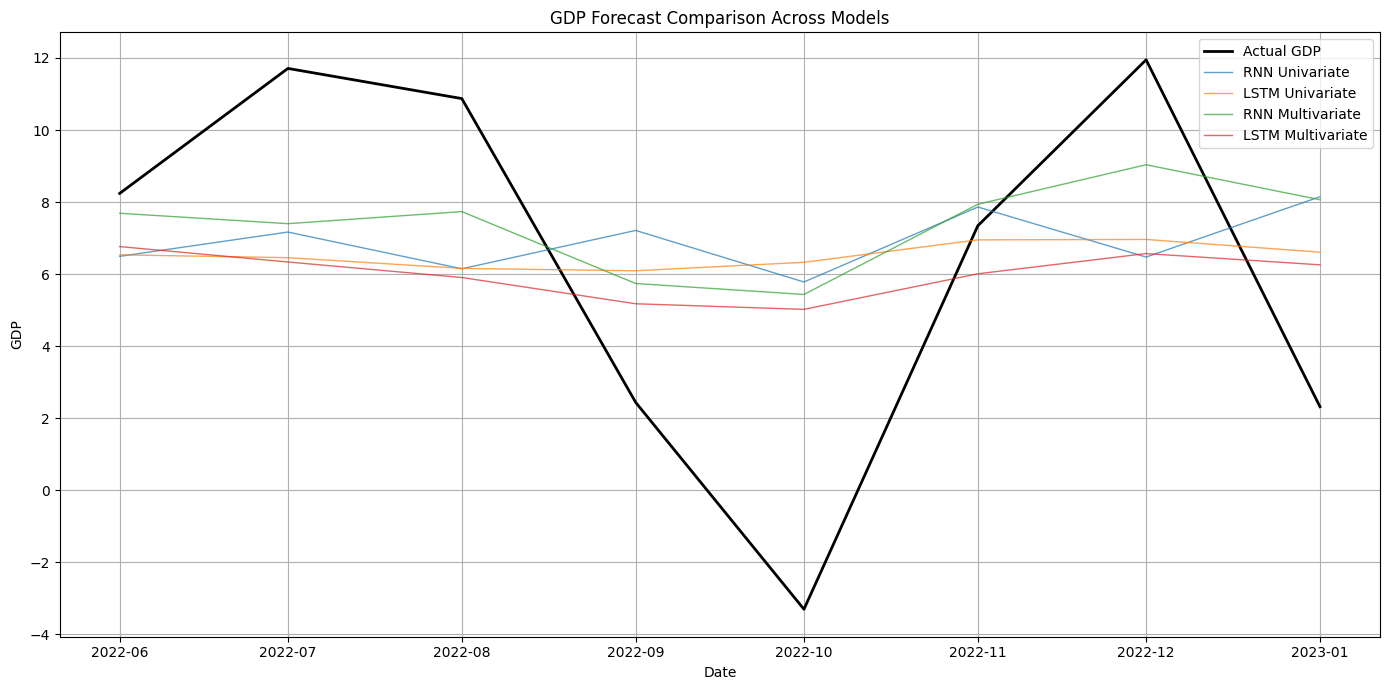

In [113]:
# Align predictions with original dates for plotting
def get_prediction_dates(generator, original_dates):
    # Calculate the start index based on the generator length
    start_idx = len(original_dates) - len(generator.targets)
    return original_dates[start_idx:]

# Get dates for univariate and multivariate predictions
dates_univariate = get_prediction_dates(val_gen_univariate, data.index)
dates_multivariate = get_prediction_dates(val_gen_multivariate, data.index)

# Ensure that dates and predictions have the same length
dates_univariate = dates_univariate[:len(predictions['RNN_Univariate']['preds'])]
dates_multivariate = dates_multivariate[:len(predictions['RNN_Multivariate']['preds'])]

# Ensure the 'Actual_GDP' series has the same length as the predictions
actual_gdp_univariate = predictions['RNN_Univariate']['actual'][:len(predictions['RNN_Univariate']['preds'])]

# Create DataFrame for univariate models
predictions_univariate = pd.DataFrame({
    'Date': dates_univariate,
    'Actual_GDP': actual_gdp_univariate,
    'RNN_Univariate': predictions['RNN_Univariate']['preds'],
    'LSTM_Univariate': predictions['LSTM_Univariate']['preds']
})

# Create DataFrame for multivariate models
predictions_multivariate = pd.DataFrame({
    'Date': dates_multivariate,
    'RNN_Multivariate': predictions['RNN_Multivariate']['preds'],
    'LSTM_Multivariate': predictions['LSTM_Multivariate']['preds']
})

# Merge both DataFrames on 'Date'
predictions_df = pd.merge(predictions_univariate, predictions_multivariate, on='Date')

# Set 'Date' as the index
predictions_df.set_index('Date', inplace=True)

print("\nPredictions DataFrame:")
print(predictions_df.head())

# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(predictions_df.index, predictions_df['Actual_GDP'], label='Actual GDP', color='black', linewidth=2)

plt.plot(predictions_df.index, predictions_df['RNN_Univariate'], label='RNN Univariate', alpha=0.7, linewidth=1)
plt.plot(predictions_df.index, predictions_df['LSTM_Univariate'], label='LSTM Univariate', alpha=0.7, linewidth=1)
plt.plot(predictions_df.index, predictions_df['RNN_Multivariate'], label='RNN Multivariate', alpha=0.7, linewidth=1)
plt.plot(predictions_df.index, predictions_df['LSTM_Multivariate'], label='LSTM Multivariate', alpha=0.7, linewidth=1)

plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('GDP Forecast Comparison Across Models')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [18]:
# Convert to numpy arra
GDPR = np.array(data["GDP"])

# Add dimension to conform the input shape array
GDPR = np.expand_dims(GDPR, 1)

# Instantiate time series generator
train_generatorRNN = TimeseriesGenerator(GDPR, GDPR, length=4, batch_size=12)

In [22]:
# Defining the sequential model
modelRNN = tf.keras.models.Sequential()

# Add input layer
modelRNN.add(tf.keras.Input(shape=(4,1)))

# Define recurrent layer
modelRNN.add(tf.keras.layers.SimpleRNN(2))

# Define output layer
modelRNN.add(tf.keras.layers.Dense(1, activation="linear"))

# Compile the model
modelRNN.compile(loss="mse", optimizer="adam")

# Fit model to data using generator
modelRNN.fit(train_generatorRNN, epochs=100, callbacks=callbacks, verbose=0)

######### LSTM ##########
# Defining the sequential model
modelLSTM = tf.keras.models.Sequential()

# Add input layer
modelLSTM.add(tf.keras.Input(shape=(4,1)))

# Define recurrent layer
modelLSTM.add(tf.keras.layers.LSTM(2))

# Define output layer
modelLSTM.add(tf.keras.layers.Dense(1, activation="linear"))

# Compile the model
modelLSTM.compile(loss="mse", optimizer="adam")

# Fit model to data using generator
modelLSTM.fit(train_generatorRNN, epochs=100, callbacks=callbacks, verbose=0)


  0%|          | 0/100 [00:00<?, ?epoch/s]c:\Users\henrik.knudsen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
100%|██████████| 100/100 [00:03<00:00, 25.10epoch/s, loss=13] 


In [24]:
# The different models
print(modelRNN.summary())
print(modelLSTM.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (144.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24 (100.00 B)

None


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107 (432.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72 (292.00 B)

None
